# Biblioteca

In [1]:
# qiskit - para computação quântica
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister # registradores e circuitos quânticos
from qiskit.primitives import StatevectorSampler as Sampler # amostragem de vetores de estado
from qiskit.circuit.library import UnitaryGate # portas unitárias

# scipy - para manipulação de matrizes
from scipy.linalg import svd # decomposição em valores singulares

# numpy - para manipulação de arrays
import numpy as np 

# random - para geração de números aleatórios
import random 

# Quantum State Preparation - QSP

Funções para Preparação dos Estados

In [2]:
# função para preparar um estado quântico, recebe o circuito, o estado e uma lista com os qubits do circuito
# c - circuito quântico
# s - estado quântico
# q - lista com os qubits do circuito
# n - número de qubits
# k - metade do número de qubits
# U, Vt - matrizes da decomposição em valores singulares
def prepare_state(c, s, q):

    # fase 1 - preparação dos qubits
    n = len(q) # número de qubits

    # se n for 1, inicializa o qubit com o estado
    if n == 1:
        c.initialize(s, q)
        return # se n for maior que 1, continua...

    # divide o estado em duas partes
    k = n // 2 

    # reshape do estado para permitir o uso da função svd
    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    s = s.reshape((dim1, dim2))

    # decomposição em valores singulares
    U, singular_values, Vt = svd(s)
    singular_values = singular_values / np.linalg.norm(singular_values)

    # chamada recursiva para preparar metade dos qubits
    prepare_state(c, singular_values, q[:k])

    # fase 2 - combinação dos qubits
    for i in range(k):
        c.cx(q[i], q[i + k])

    # fase 3 - gate unitária para a matriz U
    U_gate = UnitaryGate(U, label="U")
    c.append(U_gate, q[:k])

    # fase 4 - gate unitária para a matriz Vt
    Vt_gate = UnitaryGate(Vt.T.conj(), label="Vt")
    c.append(Vt_gate, q[k:])

In [3]:
# função para preparar um estado quântico arbitrário
# n - número de qubits
# s - vetor de amplitudes do estado
# c - circuito quântico
def prepare_arbitrary_state(n, s):
    c = QuantumCircuit(n) # cria um circuito quântico com n qubits

    # chama a função prepare_state para preparar o estado
    prepare_state(c, s, list(range(n)))

    return c # retorna o circuito

Gerador de Amplitude Aleatória

In [4]:
# função para gerar um vetor de estado aleatório
# n - número de qubits
# s - vetor de amplitudes do estado
def gen_random_state(n):
    # gera um vetor de estado aleatório
    s = np.random.rand(2**n) + 1j * np.random.rand(2**n)  
    s = s / np.linalg.norm(s) 

    return s # retorna o vetor de estado

# Quantum Error Correction - QEC

Medição de Estados

In [5]:
# ignora a medição para gerar circuitos maiores
ignore_measuring = False

# função para medir o estado atual
# c - circuito quântico
# n - número de qubits
# m - cópia do circuito original feito para medição
# sp - statevector sampler
# r - resultado da medição
# e - execução do circuito
def measure_current_state(c, n):
    if ignore_measuring:
        return
    
    # cria um circuito de measure que copia o circuito original para testar sem alterar o original
    m = c.copy()

    # registrador classico    
    reg = ClassicalRegister(n, "registrador")
    m.add_register(reg) # adiciona o registrador ao circuito
    
    # mede n qubits 
    for i in range(n):
        m.measure(i, reg[i])

    # executa o circuito
    sp = Sampler()
    e = sp.run([m])
    r = e.result() # coleta o resultado da medição
    
    print(r[0].data.registrador.get_counts()) # imprime o resultado da medição
    print("")

Função de Codificação de Shor

In [142]:
# função para codificar um qubit em um estado de 9 qubits como descrito no artigo
# c - circuito quântico
# n - número de qubits
# extra_q - registrador extra
def encode_qubit(c, n):

    # cria um registrador extra
    extra_q = QuantumRegister(8*n, name="extra_q")  
    c.add_register(extra_q) # adiciona o registrador ao circuito
     
    # codifica n qubits em estados de 9 qubits cada
    for i in range(n):

        c.cx(i,8*i + 3 + (n-1))
        c.cx(i,8*i + 6 + (n-1))

        #c.h(i)
        #c.h(8*i + 3 + (n-1))
        #c.h(8*i + 6 + (n-1))

        c.cx(i,8*i + 1 + (n-1))
        c.cx(8*i + 3 + (n-1),8*i + 4 + (n-1))
        c.cx(8*i + 6 + (n-1),8*i + 7 + (n-1))

        c.cx(i,8*i + 2 + (n-1))
        c.cx(8*i + 3 + (n-1),8*i + 5 + (n-1))
        c.cx(8*i + 6 + (n-1),8*i + 8 + (n-1))
        
        c.barrier()

    return c # retorna o circuito após aplicar vários CNOTS e HADAMARDS

Função de Aplicar Erro Aleatório

In [7]:
# função para aplicar um erro aleatório em um dos qubits
# c - circuito quântico
# n - número de qubits
# error_q - qubit que receberá o erro
# error - tipo de erro (x ou z)
def apply_random_error(c, n):
    error_q = random.randint(0, (n*9)-1) # escolhe um qubit aleatório para receber o erro
    error = random.choice(['x', 'z']) # escolhe um erro aleatório (x ou z)
    
    # aplica o erro no qubit escolhido
    if error == 'x':
        c.x(error_q) # aplica a porta X no circuito
    else:
        c.z(error_q) # aplica a porta Z no circuito

    # coloca uma barreira no circuito
    c.barrier()

    # retorna o circuito com o erro aplicado
    return c

Extração de Síndrome

In [92]:
# função para extrair o síndrome de um estado de 9 qubits
# c - circuito quântico
# sp - statevector sampler
# syn_anc_x - síndrome X
# syn_anc_z - síndrome Z
# syn_cr_x - registrador clássico para o síndrome X
# syn_cr_z - registrador clássico para o síndrome Z
# l_syn_x - lista de síndromes X
# l_syn_z - lista de síndromes Z
def extract_syndrome(c):
    sp = Sampler() 

    # cria os registradores para o síndrome
    syn_anc_x = QuantumRegister(3, name="syn_x")  
    syn_anc_z = QuantumRegister(3, name="syn_z") 
    syn_cr_x  = ClassicalRegister(3, name="syn_cx")
    syn_cr_z  = ClassicalRegister(3, name="syn_cz")
    
    # adiciona os registradores ao circuito
    c.add_register(syn_anc_x)
    c.add_register(syn_anc_z)
    c.add_register(syn_cr_x)
    c.add_register(syn_cr_z)

    # listas para armazenar as síndromes
    l_syn_x = []
    l_syn_z = []
    
    # extrai o síndrome de cada qubit
    for j in range(3):
        b = j * 3

        ###### X ########
        c.cx(c.qubits[b],   syn_anc_x[j])
        c.cx(c.qubits[b+1], syn_anc_x[j])
        c.cx(c.qubits[b+2], syn_anc_x[j])

        copy_c = c.copy()
        copy_c.measure(syn_anc_x[j], syn_cr_x[j])

        e = sp.run([copy_c])
        result = e.result()      
        
        l_syn_x.append(result[0].data.syn_cx.get_counts())
        l_syn_z.append(result[0].data.syn_cz.get_counts())
        
        c.barrier()###### 

        ###### Z ########
        c.h(c.qubits[b])
        c.h(c.qubits[b+1])
        c.h(c.qubits[b+2])

        c.cx(c.qubits[b],   syn_anc_z[j])
        c.cx(c.qubits[b+1], syn_anc_z[j])
        c.cx(c.qubits[b+2], syn_anc_z[j])

        c.h(syn_anc_z[j])

        copy_c = c.copy()
        copy_c.measure(syn_anc_z[j], syn_cr_z[j])

        e = sp.run([copy_c])
        result = e.result()       
        
        l_syn_x.append(result[0].data.syn_cx.get_counts())
        l_syn_z.append(result[0].data.syn_cz.get_counts())

        c.barrier()######

    # retorna o circuito e as listas de síndromes
    return c, l_syn_x, l_syn_z

Corrigir Erros

In [96]:
# função para corrigir um erro em um estado de 9 qubits
# c - circuito quântico
# n - número de qubits
# syn_x - síndrome X
# syn_z - síndrome Z
# b_block - bloco de bits
def correct_error(c, n, syn_x, syn_z):
    
    # função para extrair o bit de erro
    def extract_error_bit(d):
        outcome = max(d, key=d.get)
        return 0 if outcome == "000" else 1

    # corrige o erro em cada qubit
    for logical in range(n):
        
        b_block = logical * 9

        for j in range(3):
            idx1 = logical * 6 + 2 * j
            idx2 = logical * 6 + 2 * j + 1
            
            error_bit_x = 1 if (extract_error_bit(syn_x[idx1]) or extract_error_bit(syn_x[idx2])) else 0
            error_bit_z = 1 if (extract_error_bit(syn_z[idx1]) or extract_error_bit(syn_z[idx2])) else 0
            
            block_start = b_block + j * 3
            
            if error_bit_x:
                c.x(c.qubits[block_start])
            if error_bit_z:
                c.z(c.qubits[block_start])
    
    ##############################
    
    c.barrier() # coloca uma barreira no circuito

    return c


Função de Decodificação de Shor

In [141]:
# função para decodificar um qubit de 9 qubits
# c - circuito quântico
# n - número de qubits
def decode_qubit(c, n):

    for i in range(n): 
        c.cx(i, i*8 + n) 
        
        c.cx(i*8 + n + 2, i*8 + n + 3) 
        c.cx(i*8 + n + 5, i*8 + n + 6) 

        c.cx(i, i*8 + n + 1)

        c.cx(i*8 + n + 2, i*8 + n + 4) 
        c.cx(i*8 + n + 5, i*8 + n + 7) 

        c.ccx(i*8 + n, i*8 + n + 1, i) 
        c.ccx(i*8 + n + 4, i*8 + n + 3, i*8 + n + 2) 
        c.ccx(i*8 + n + 7, i*8 + n + 6, i*8 + n + 5) 

        #c.h(i) 
        #c.h(i*8 + n + 2)
        #c.h(i*8 + n + 5)

        c.cx(i, i*8 + n + 2) 
        c.cx(i, i*8 + n + 5) 
        c.ccx(i*8 + n + 5, i*8 + n + 2, i) 

        c.barrier()
    
    return c

Controlador do Corretor de Erros Quântico

In [146]:
# função de controle
# c - circuito quântico
# n - número de qubits
def qec(c, n):

    print("Estados iniciais:")
    measure_current_state(c, n)
        
    ###########################################
    #''' Código de Shor
    encode_qubit(c, n)

    print("Estados pós codificação de Shor:")
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' Aplicar erro
    apply_random_error(c, n)

    print("Estados pós aplicação de erro:")
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' Extração da síndrome
    copy_c = c.copy()
    _, synX, synZ = extract_syndrome(copy_c)

    print("Estados pós extração de síndrome:")
    print("Síndrome X:")
    print(synX)
    print("Síndrome Z:")
    print(synZ)
    print("")

    #'''

    ###########################################
    #''' Correção do erro
    correct_error(c, n, synX, synZ)

    print("Estados pós correção de erro:")
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' Decodificação

    print("Estados pós decode:")
    decode_qubit(c, n)
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' Aplicação da Hadamard transversal
    # (Preserva a codificação sem decodificar)
    hadamard_circuit = c.copy()
    for block in range(n):
        base = block * 9
        hadamard_circuit.h(range(base, base + 9))
    
    print("Estados pós Hadamard transversal:")
    measure_current_state(hadamard_circuit, n*9)
    
    #'''

    ###########################################    
    print("Estados finais:")
    measure_current_state(c, n)

    return c

# Aplicações

Aplicação QSP

{'1110': 79, '1111': 121, '1000': 62, '0100': 46, '0110': 105, '0101': 120, '1010': 81, '0011': 47, '1001': 32, '1011': 44, '0000': 124, '1101': 18, '1100': 89, '0111': 15, '0010': 13, '0001': 28}



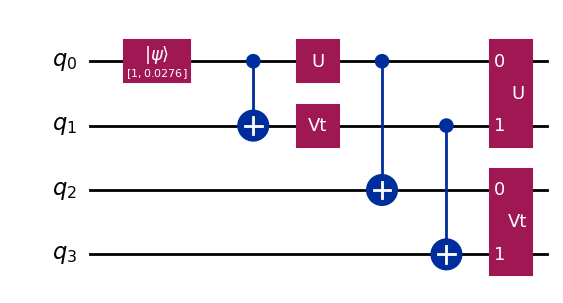

In [71]:
n = int(input('Insira o número de qubits que quer preparar: ')) # número de qubits

# prepara o circuito quântico com o estado e o número de qubits especificados
c = prepare_arbitrary_state(n, gen_random_state(n))

# mede o estado atual
measure_current_state(c, n)

# desenha o circuito
c.draw('mpl')

Aplicação QEC

Estados iniciais:
{'1': 858, '0': 166}

Estados pós codificação de Shor:
{'111111111': 860, '000000000': 164}

Estados pós aplicação de erro:
{'111110111': 850, '000001000': 174}

Estados pós extração de síndrome:
Síndrome X:
[{'001': 865, '000': 159}, {'000': 1024}, {'000': 837, '010': 187}, {'000': 1024}, {'000': 161, '100': 863}, {'000': 1024}]
Síndrome Z:
[{'000': 1024}, {'001': 506, '000': 518}, {'000': 1024}, {'010': 527, '000': 497}, {'000': 1024}, {'000': 511, '100': 513}]

Estados pós correção de erro:
{'110110110': 856, '001001001': 168}

Estados pós decode:
{'110110111': 870, '110110110': 154}

Estados pós Hadamard transversal:
{'011100010': 8, '000001010': 3, '110000000': 9, '011100110': 6, '011101110': 5, '101100010': 3, '111110000': 3, '001010101': 1, '011010110': 3, '101110100': 6, '100001010': 2, '110100000': 4, '110001100': 5, '101001110': 4, '111010000': 3, '000010000': 7, '000010010': 4, '100010000': 3, '011010101': 3, '110001111': 2, '010111111': 2, '101011100': 5, 

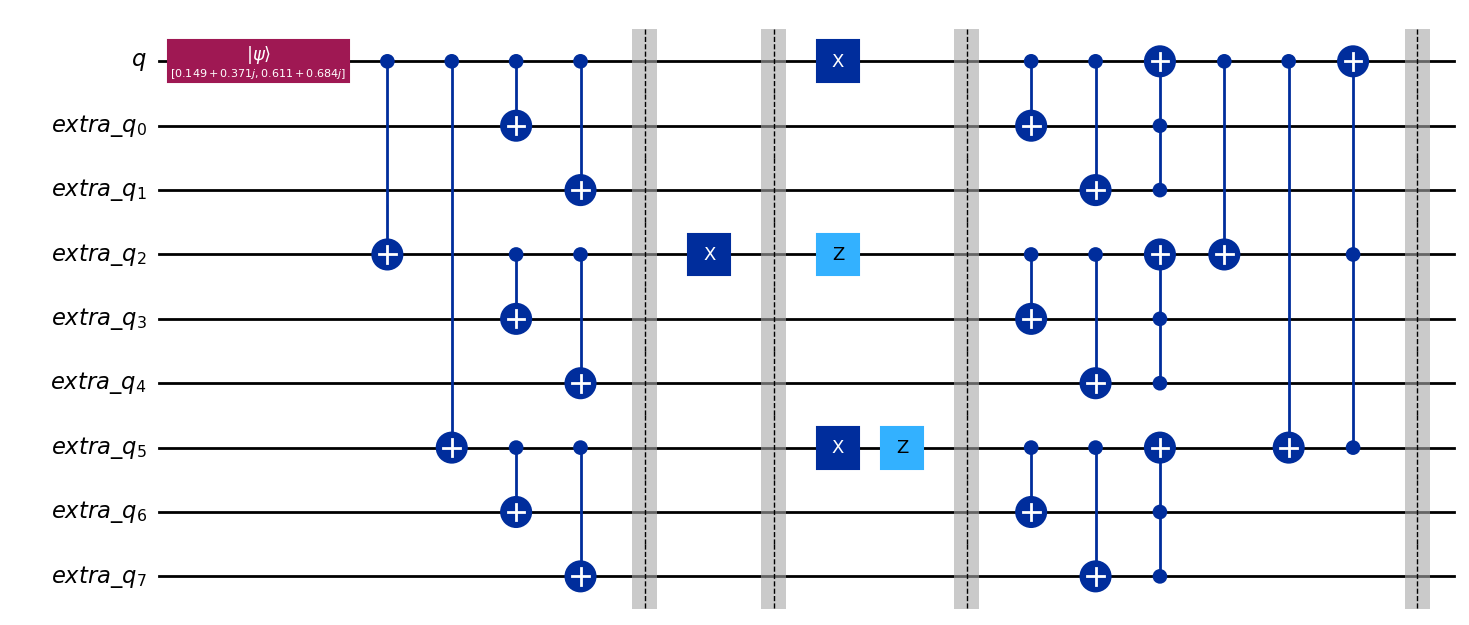

In [183]:
# variável para ignorar a medição ou não (True para ignorar)
ignore_measuring = False

# dificuldade para gerar com qualquer quantidade maior que 1 qubit
n = 1 # int(input('Insira o número de qubits que quer preparar: '))  # selecionar o número de qubits

# prepara o estado aleatório com n qubits
c = prepare_arbitrary_state(n, gen_random_state(n))

qec(c, n) # executa o código de correção de erro

# desenhar circuito
c.draw('mpl')